# NCAA March Madness

In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None) # Esto es para que se vean todas las columnas

# PREPARACIÓN DE LOS DATOS

In [2]:
# Cargamos los datos

df_seeds = pd.concat([pd.read_csv('data/MNCAATourneySeeds.csv'), pd.read_csv('data/WNCAATourneySeeds.csv')], axis=0)
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [3]:
df_season_results = pd.concat([pd.read_csv('data/MRegularSeasonCompactResults.csv'), pd.read_csv('data/WRegularSeasonCompactResults.csv')], axis=0)

df_season_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)

In [4]:
df_season_results['ScoreDiff'] = df_season_results['WScore'] - df_season_results['LScore']

In [5]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreDiff
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


# FEATURE ENGINEERING

Para cada equipo en cada temporada, calculo:

Número de victorias
Número de derrotas
Promedio de brecha de puntuación de victorias
Promedio de brecha de puntuación de derrotas

Y uso las siguientes características:

Proporción de victorias
Promedio de brecha de puntuación

In [6]:
# Agrupa los resultados de la temporada por 'Season' y 'WTeamID' y cuenta el número de victorias
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()

# Restablece el índice, selecciona columnas específicas y renombra para mayor claridad
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'NumWins', 'WTeamID': 'TeamID'})  # 'NumWins' ahora representa el número de victorias por temporada

# Similar al proceso de conteo de victorias, pero para las pérdidas
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()

# Nuevamente, restablece el índice, selecciona columnas y renombra para mayor claridad
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'NumLosses', 'LTeamID': 'TeamID'})  # 'NumLosses' ahora representa el número de pérdidas por temporada

# Calcula la diferencia promedio de puntos en los partidos ganados
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()

# Selecciona las columnas relevantes y renombra para mayor claridad
gap_win = gap_win[['Season', 'WTeamID', 'ScoreDiff']].rename(columns={'ScoreDiff': 'GapWins', 'WTeamID': 'TeamID'})  # 'GapWins' ahora representa la diferencia promedio de puntos en los partidos ganados

# Calcula la diferencia promedio de puntos en los partidos perdidos
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()

# Selecciona las columnas relevantes y renombra para mayor claridad
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreDiff']].rename(columns={'ScoreDiff': 'GapLosses', 'LTeamID': 'TeamID'})  # 'GapLosses' ahora representa la diferencia promedio de puntos en los partidos perdidos

In [7]:
### Merge

# Agrupa los resultados de la temporada por 'Season' y 'WTeamID', cuenta las entradas para cada combinación única,
# resetea el índice, selecciona las columnas 'Season' y 'WTeamID' y renombra 'WTeamID' a 'TeamID'
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})

# Realiza los mismos pasos que el anterior, pero para los equipos perdedores
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

# Une los dos DataFrames a lo largo del eje 0, elimina las filas duplicadas, ordena el DataFrame por 'Season' y 'TeamID',
# y resetea el índice descartando el antiguo
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


In [8]:
# Une (merge) el DataFrame de características con el DataFrame de número de victorias por 'Season' y 'TeamID', llenando con NA/NaN cualquier valor faltante
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')

# Hace lo mismo con el DataFrame de número de pérdidas
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')

# Hace lo mismo con el DataFrame de diferencia de puntos promedio en partidos ganados
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')

# Hace lo mismo con el DataFrame de diferencia de puntos promedio en partidos perdidos
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [9]:
### Características de computación

# Calcula la proporción de victorias dividiendo el número de victorias por el total de partidos jugados
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])

# Calcula la diferencia promedio de puntos como un promedio ponderado de la diferencia de puntos en partidos ganados y perdidos
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)


In [10]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [11]:
df_features_season.head()

,Season,TeamID,WinRatio,GapAvg
0,1985,1102,0.208333,-5.791667
1,1985,1103,0.391304,-3.043478
2,1985,1104,0.700000,7.800000
3,1985,1106,0.416667,-3.791667
4,1985,1108,0.760000,7.960000


### Tourney Results

In [12]:
df_tourney_results = pd.concat([pd.read_csv('data/MNCAATourneyCompactResults.csv'), pd.read_csv('data/WNCAATourneyCompactResults.csv')], axis=0)

In [13]:
# Train Data

df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2016,134,1195,96,1192,65,N,0
1,2016,134,1455,70,1435,50,N,0
2,2016,135,1221,59,1380,55,N,0
3,2016,135,1276,67,1409,62,N,0
4,2016,136,1114,85,1345,83,N,2


In [14]:
### Seeds

### SeedW is the seed of the winning team
### SeedL is the seed of the losing team

df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [15]:
df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [16]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [17]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [18]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SeedW,SeedL
0,2016,134,1195,96,1192,65,N,0,16,16
1,2016,134,1455,70,1435,50,N,0,11,11
2,2016,135,1221,59,1380,55,N,0,16,16
3,2016,135,1276,67,1409,62,N,0,11,11
4,2016,136,1114,85,1345,83,N,2,12,5


In [19]:
### Season Stats

### WinRatioW is the win ratio of the winning team during the season
### WinRatioL is the win ratio of the losing team during the season

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [20]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [21]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2016,134,1195,96,1192,65,N,0,16,16,0.551724,2.724138,0.548387,-1.677419
1,2016,134,1455,70,1435,50,N,0,11,11,0.741935,13.709677,0.593750,9.406250
2,2016,135,1221,59,1380,55,N,0,16,16,0.424242,-4.333333,0.612903,1.870968
3,2016,135,1276,67,1409,62,N,0,11,11,0.636364,6.242424,0.645161,4.322581
4,2016,136,1114,85,1345,83,N,2,12,5,0.870968,9.935484,0.764706,13.147059


In [22]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA",
        "WScore" : "ScoreA",
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

    lose_rename = {
        "WTeamID": "TeamIdB",
        "WScore" : "ScoreB",
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

    win_df = df.copy()
    lose_df = df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [23]:
df = add_loosing_matches(df)

In [24]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2016,134,1195,96,1192,65,N,0,16,16,0.551724,2.724138,0.548387,-1.677419
1,2016,134,1455,70,1435,50,N,0,11,11,0.741935,13.709677,0.593750,9.406250
2,2016,135,1221,59,1380,55,N,0,16,16,0.424242,-4.333333,0.612903,1.870968
3,2016,135,1276,67,1409,62,N,0,11,11,0.636364,6.242424,0.645161,4.322581
4,2016,136,1114,85,1345,83,N,2,12,5,0.870968,9.935484,0.764706,13.147059


In [25]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [26]:
### Target

df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [27]:
### Modeling

features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [28]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()

    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)

    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)

    return df_train, df_val, df_test

In [29]:
# Ahora vamos a ver los datasets de entrenamiento y validación

df_train = df[df['Season'] <= 2021]
df_val = df[df['Season'] == 2022]

In [30]:
# Vamos a escalar los datos

df_train, df_val, _ = rescale(features, df_train, df_val)

/var/folders/b7/wmcd_tzj3hd8lsdlfgr85gb40000gn/T/ipykernel_25860/3134456131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[features] = (df_train[features] - min_) / (max_ - min_)
/var/folders/b7/wmcd_tzj3hd8lsdlfgr85gb40000gn/T/ipykernel_25860/3134456131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[features] = (df_val[features] - min_) / (max_ - min_)


In [31]:
df_train

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2016,134,1195,96,1192,65,N,0,1.000000,1.000000,0.233335,0.191212,0.227227,0.071958,0.500000,0.503552,0.570536,31,1
1,2016,134,1455,70,1435,50,N,0,0.666667,0.666667,0.581487,0.488850,0.310257,0.372255,0.500000,0.657746,0.568963,20,1
2,2016,135,1221,59,1380,55,N,0,1.000000,1.000000,0.000000,0.000000,0.345314,0.168097,0.500000,0.299168,0.400575,4,1
3,2016,135,1276,67,1409,62,N,0,0.666667,0.666667,0.388254,0.286535,0.404357,0.234520,0.500000,0.490635,0.530766,5,1
4,2016,136,1114,85,1345,83,N,2,0.733333,0.266667,0.817660,0.386594,0.623165,0.473607,0.733333,0.613117,0.448534,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,2021,148,3400,34,3376,62,N,0,0.333333,0.000000,0.443719,0.309068,0.772242,0.591544,0.666667,0.308933,0.332923,-28,0
712,2021,148,3257,63,3390,78,N,0,0.066667,0.000000,0.842640,0.574871,0.918253,0.813811,0.533333,0.456024,0.358673,-15,0
713,2021,151,3163,59,3112,69,N,0,0.000000,0.133333,0.980620,0.971396,0.618038,0.402533,0.433333,0.710876,0.836468,-10,0
714,2021,151,3376,65,3390,66,N,0,0.000000,0.000000,0.772242,0.591544,0.918253,0.813811,0.500000,0.415081,0.368534,-1,0


In [32]:
df_train.isna().sum()

Season           0
DayNum           0
TeamIdA          0
ScoreA           0
TeamIdB          0
ScoreB           0
WLoc             0
NumOT            0
SeedA            0
SeedB            0
WinRatioA       22
GapAvgA         22
WinRatioB       22
GapAvgB         22
SeedDiff         0
WinRatioDiff    44
GapAvgDiff      44
ScoreDiff        0
WinA             0
dtype: int64

In [33]:
df_train = df_train.fillna(0)

Preparación de los datos: Carga los datos de los archivos .csv, fusiona los datos de los torneos masculinos y femeninos, elimina algunas columnas y agrega una nueva columna que representa la diferencia de puntuación entre los equipos ganadores y perdedores.

Ingeniería de características: Para cada equipo en cada temporada, calcula el número de victorias, el número de derrotas, el promedio de la brecha de puntuación de las victorias y el promedio de la brecha de puntuación de las derrotas. Después de esto, calcula la proporción de victorias y el promedio de la brecha de puntuación como características.

Resultados del Torneo: Carga los resultados del torneo y prepara los datos de entrenamiento.

Semillas: Asigna las semillas (una clasificación pre-torneo asignada a cada equipo basada en su rendimiento durante la temporada regular) a los equipos ganadores y perdedores.

Estadísticas de la temporada: Combina las estadísticas de la temporada con los resultados del torneo para agregar características adicionales.

Añadir partidos perdidos: Crea dos versiones de cada partido en el conjunto de datos, una desde la perspectiva del equipo ganador y otra desde la perspectiva del equipo perdedor.

Diferencias de características: Calcula las diferencias entre las características de los equipos ganadores y perdedores para cada partido.



In [34]:
# Comenzamos con los datos de entrenamiento

# Selecciona las características y la variable objetivo
X = df_train[features]
y = df_train['WinA']

# Dividimos los datos en entrenamiento y validación

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Creamos un modelo random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [36]:
# Realizamos predicciones en el conjunto de validación

y_pred = model.predict_proba(X_val)[:, 1]

In [37]:
# Evaluamos el modelo con accuracy y confusion matrix

from sklearn.metrics import accuracy_score, confusion_matrix

print(f'Accuracy: {accuracy_score(y_val, y_pred > 0.5)}')
print(f'Confusion matrix: \n{confusion_matrix(y_val, y_pred > 0.5)}')

Accuracy: 0.7230769230769231
Confusion matrix: 
[[95 29]
 [43 93]]


In [38]:
# Vamos a ver la precisión del modelo en el conjunto de validación

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

print(f'La precisión del modelo es: {roc_auc_score(y_val, y_pred)}')

La precisión del modelo es: 0.8194378557874764


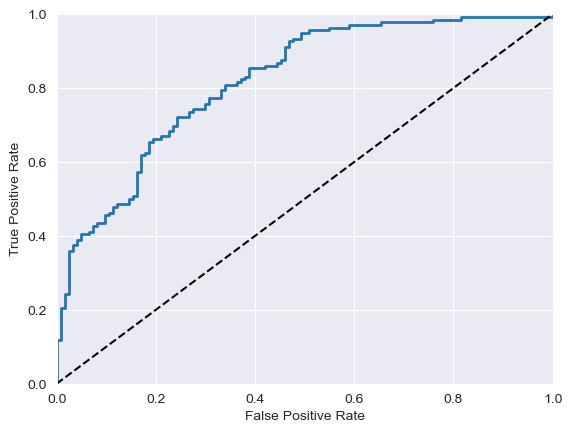

In [39]:
# Vamos a ver la curva ROC

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

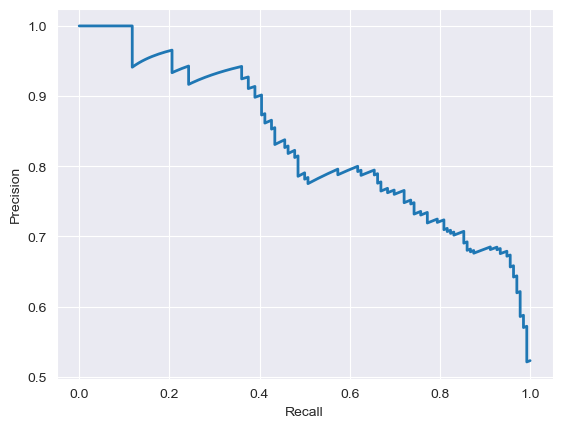

In [40]:
# Vamos a ver la curva de precision-recall

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [41]:
# Vamos a ver el promedio de precisión

average_precision_score(y_val, y_pred)

0.8317195208056718

In [42]:
# Vamos a ver la importancia de las características

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importances[indices[f]]))

 1) SeedDiff                       0.274170
 2) SeedB                          0.183340
 3) SeedA                          0.168266
 4) GapAvgDiff                     0.102380
 5) GapAvgA                        0.071238
 6) GapAvgB                        0.059754
 7) WinRatioDiff                   0.056744
 8) WinRatioA                      0.045363
 9) WinRatioB                      0.038744


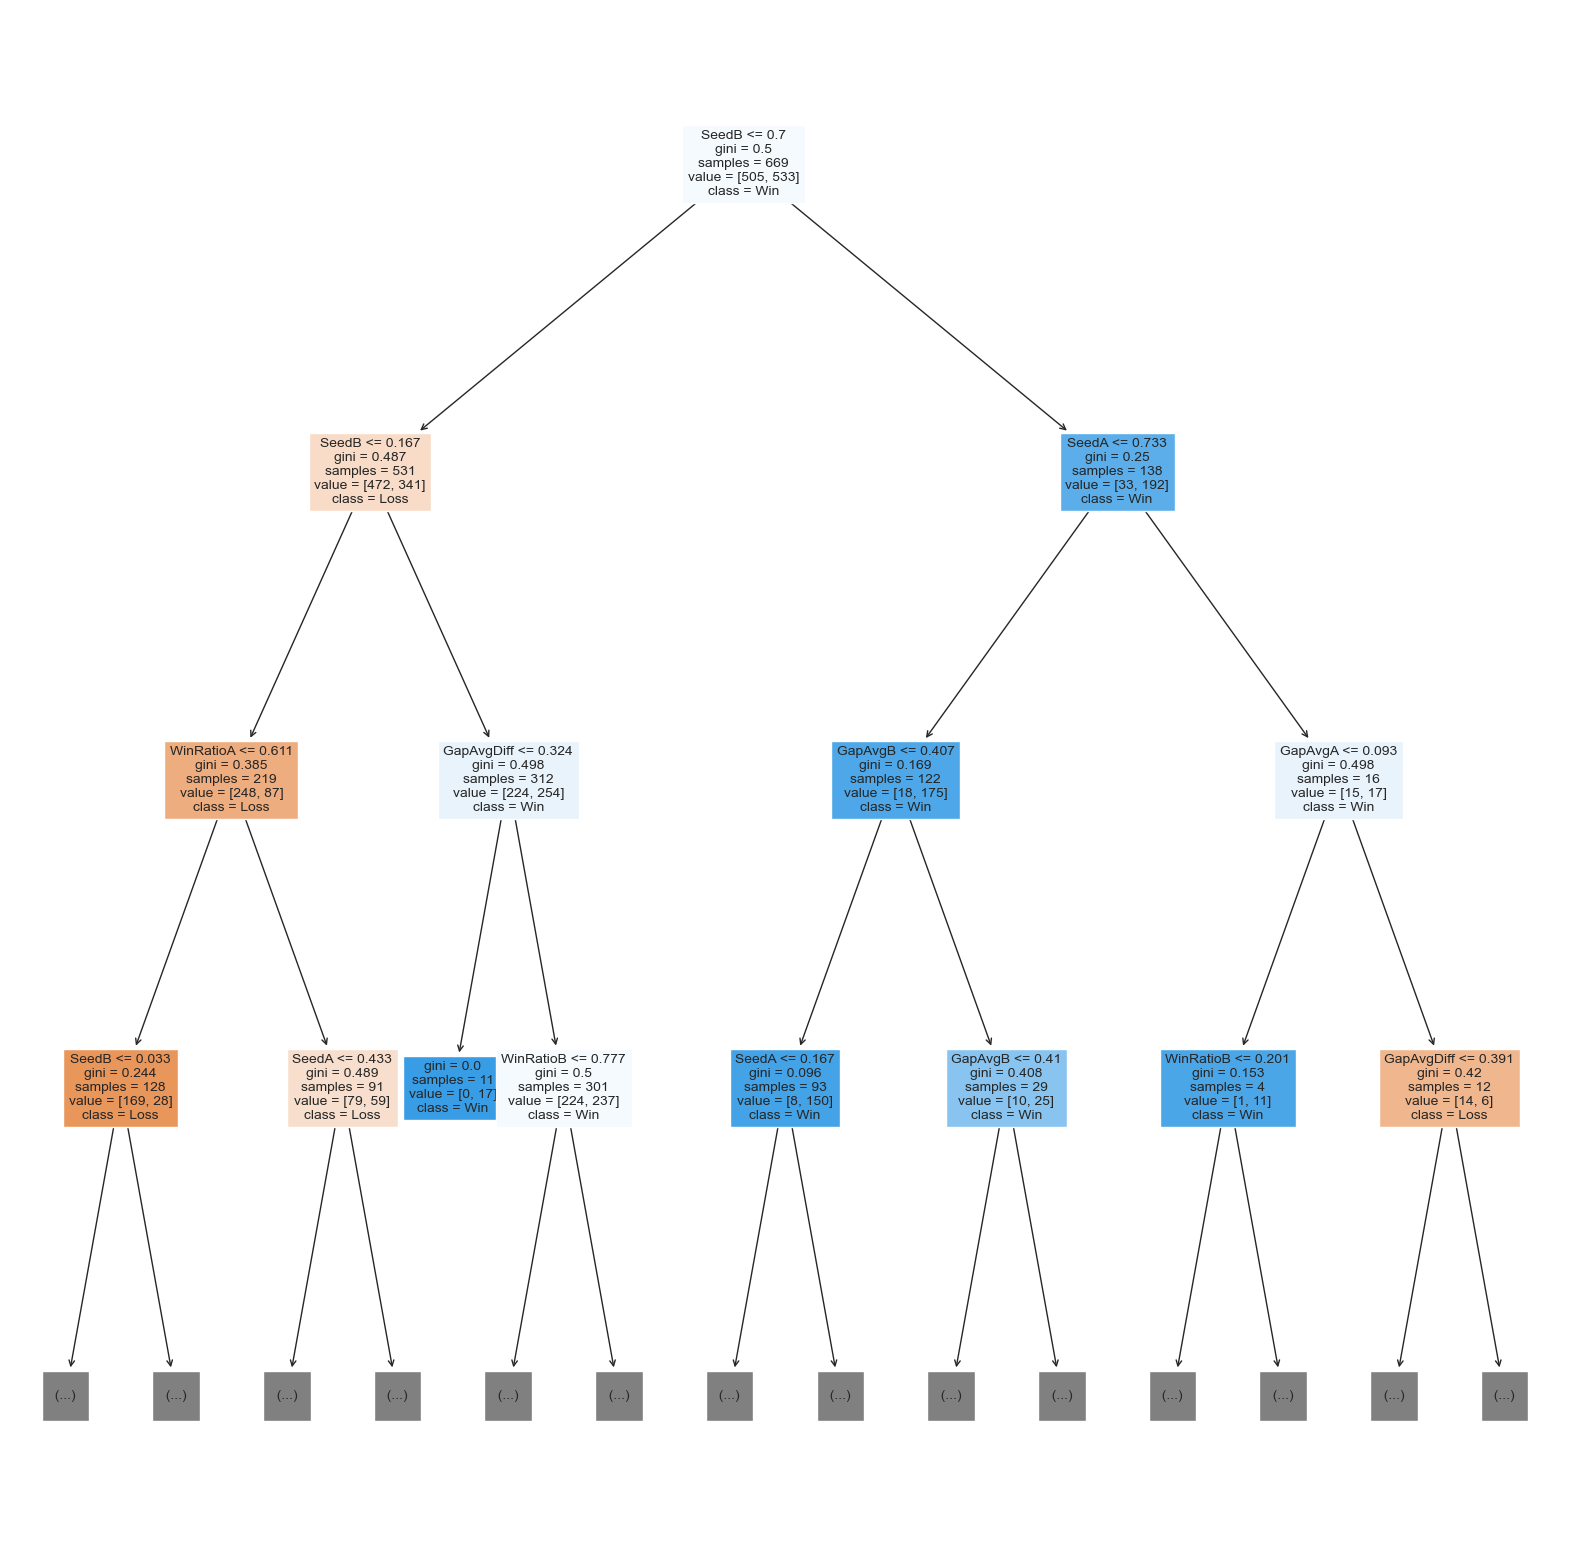

In [43]:
# Vamos a ver el árbol de decisión

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Elige uno de los árboles del bosque aleatorio
estimator = model.estimators_[5]

plt.figure(figsize=(20,20))
plot_tree(estimator,
          feature_names=features,
          class_names=['Loss', 'Win'],
          filled=True,
          impurity=True,
          fontsize=10,
          max_depth=3)
plt.show()

In [44]:
# Vamos a guarda el modelo en un archivo pickle en el directorio actual

import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [45]:
# Vamos a usar el modelo para hacer predicciones en el Data/SampleSubmission2023.csv

df_sample_sub = pd.read_csv('Data/SampleSubmission2023.csv')
df_sample_sub

,ID,Pred
0,2023_1101_1102,0.5
1,2023_1101_1103,0.5
2,2023_1101_1104,0.5
3,2023_1101_1105,0.5
4,2023_1101_1106,0.5
...,...,...
130678,2023_3474_3476,0.5
130679,2023_3474_3477,0.5
130680,2023_3475_3476,0.5
130681,2023_3475_3477,0.5


In [46]:
# Vamos a crear un dataframe con las características del dataframe de muestra usando el SampleSubmission2023.csv

X_sample_sub = df_sample_sub.copy()
X_sample_sub['Season'] = X_sample_sub['ID'].apply(lambda x: int(x[:4]))
X_sample_sub['TeamA'] = X_sample_sub['ID'].apply(lambda x: int(x[5:9]))
X_sample_sub['TeamB'] = X_sample_sub['ID'].apply(lambda x: int(x[10:14]))
X_sample_sub

,ID,Pred,Season,TeamA,TeamB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


In [47]:
# Vamos a ver los datos de X_sample_sub

X_sample_sub

,ID,Pred,Season,TeamA,TeamB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


In [48]:
# Vamos a ver los datos de df_val

df_val

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
334,2022,134,1231,66,1461,58,N,0,0.733333,0.733333,0.332790,0.267652,0.596248,0.285047,0.500000,0.346774,0.489711,8,1
335,2022,134,1411,76,1394,67,N,0,1.000000,1.000000,0.321697,0.218555,0.382708,0.190558,0.500000,0.464516,0.516559,9,1
336,2022,135,1323,89,1353,87,N,2,0.666667,0.666667,0.463401,0.252874,0.286271,0.174215,0.500000,0.603018,0.546525,2,1
337,2022,135,1460,93,1136,82,N,0,1.000000,1.000000,0.332790,0.213465,0.504731,0.200493,0.500000,0.400000,0.507673,11,1
338,2022,136,1116,75,1436,71,N,0,0.200000,0.800000,0.610114,0.344828,0.767843,0.498409,0.200000,0.408266,0.409160,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2022,147,3301,87,3163,91,N,2,0.000000,0.066667,0.882239,0.641497,0.748777,0.675534,0.466667,0.577621,0.479868,-4,0
779,2022,147,3276,50,3257,62,N,0,0.133333,0.000000,0.661617,0.420273,0.801373,0.581734,0.566667,0.418719,0.404500,-12,0
780,2022,151,3390,58,3163,63,N,0,0.000000,0.066667,0.876704,0.575375,0.748777,0.675534,0.466667,0.574402,0.440759,-5,0
781,2022,151,3257,59,3376,72,N,0,0.000000,0.000000,0.801373,0.581734,0.935747,0.648790,0.500000,0.421849,0.460338,-13,0


In [49]:
# Realizar el merge
merged_df = X_sample_sub.merge(df_val, left_on=['TeamA', 'TeamB'], right_on=['TeamIdA', 'TeamIdB'], how='inner')
merged_df

,ID,Pred,Season_x,TeamA,TeamB,Season_y,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2023_1103_1417,0.5,2023,1103,1417,2022,136,1103,53,1417,57,N,0,0.800000,0.200000,0.522444,0.256370,0.653446,0.430675,0.800000,0.423810,0.396903,-4,0
1,2023_1104_1323,0.5,2023,1104,1323,2022,137,1104,64,1323,78,N,0,0.333333,0.666667,0.310257,0.213927,0.463401,0.252874,0.333333,0.410933,0.476964,-14,0
2,2023_1112_1222,0.5,2023,1112,1222,2022,143,1112,60,1222,72,N,0,0.000000,0.266667,0.892333,0.578794,0.784666,0.576403,0.366667,0.562619,0.501414,-12,0
3,2023_1112_1395,0.5,2023,1112,1395,2022,139,1112,85,1395,80,N,1,0.000000,0.533333,0.892333,0.578794,0.367455,0.201226,0.233333,0.805266,0.723322,5,1
4,2023_1112_1460,0.5,2023,1112,1460,2022,137,1112,87,1460,70,N,0,0.000000,1.000000,0.892333,0.578794,0.332790,0.213465,0.000000,0.825427,0.716083,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2023_3314_3376,0.5,2023,3314,3376,2022,144,3314,61,3376,69,N,0,0.266667,0.000000,0.675142,0.614433,0.935747,0.648790,0.633333,0.348434,0.479679,-8,0
130,2023_3323_3328,0.5,2023,3323,3328,2022,140,3323,108,3328,64,A,0,0.266667,0.200000,0.565742,0.398276,0.596248,0.314681,0.533333,0.482258,0.549444,44,1
131,2023_3326_3400,0.5,2023,3326,3400,2022,144,3326,63,3400,66,N,0,0.333333,0.066667,0.675142,0.476162,0.710644,0.550056,0.633333,0.479352,0.456293,-3,0
132,2023_3390_3400,0.5,2023,3390,3400,2022,146,3390,59,3400,50,N,0,0.000000,0.066667,0.876704,0.575375,0.710644,0.550056,0.466667,0.596579,0.514975,9,1


In [50]:
# Usamos el modelo para hacer predicciones en el conjunto de datos de muestra

y_sample_sub = model.predict_proba(merged_df[features])[:, 1]
y_sample_sub

array([0.19128751, 0.58054891, 0.71029537, 0.86297277, 0.96192454,
       0.29903676, 0.12004476, 0.74081886, 0.75300942, 0.95081901,
       0.77083902, 0.94353007, 0.76504525, 0.41904878, 0.36320923,
       0.21325915, 0.3159533 , 0.48241039, 0.75045333, 0.22665048,
       0.49761689, 0.03891455, 0.39840354, 0.13365426, 0.70374595,
       0.76074109, 0.57460894, 0.02979447, 0.87655494, 0.55839535,
       0.76756411, 0.48559685, 0.3677796 , 0.52517465, 0.79329289,
       0.46279412, 0.49630969, 0.39013914, 0.7233994 , 0.71551053,
       0.71532941, 0.92329663, 0.53891911, 0.96805858, 0.08103852,
       0.44236801, 0.51413323, 0.45133779, 0.30037019, 0.30853313,
       0.06768481, 0.51790825, 0.65800368, 0.51863385, 0.32186734,
       0.4624448 , 0.30820843, 0.3239297 , 0.52266115, 0.70592053,
       0.93690136, 0.59331963, 0.94801157, 0.45072043, 0.38806452,
       0.46158274, 0.58014901, 0.02958504, 0.06299737, 0.4801882 ,
       0.84450908, 0.43573553, 0.95547418, 0.70695253, 0.32145

In [51]:
# añadimos las predicciones al dataframe de muestra la añadimos sumandola directamente a la derecha de la columna 'WinA' del dataframe merged_df

merged_df['Pred'] = y_sample_sub
merged_df

,ID,Pred,Season_x,TeamA,TeamB,Season_y,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2023_1103_1417,0.191288,2023,1103,1417,2022,136,1103,53,1417,57,N,0,0.800000,0.200000,0.522444,0.256370,0.653446,0.430675,0.800000,0.423810,0.396903,-4,0
1,2023_1104_1323,0.580549,2023,1104,1323,2022,137,1104,64,1323,78,N,0,0.333333,0.666667,0.310257,0.213927,0.463401,0.252874,0.333333,0.410933,0.476964,-14,0
2,2023_1112_1222,0.710295,2023,1112,1222,2022,143,1112,60,1222,72,N,0,0.000000,0.266667,0.892333,0.578794,0.784666,0.576403,0.366667,0.562619,0.501414,-12,0
3,2023_1112_1395,0.862973,2023,1112,1395,2022,139,1112,85,1395,80,N,1,0.000000,0.533333,0.892333,0.578794,0.367455,0.201226,0.233333,0.805266,0.723322,5,1
4,2023_1112_1460,0.961925,2023,1112,1460,2022,137,1112,87,1460,70,N,0,0.000000,1.000000,0.892333,0.578794,0.332790,0.213465,0.000000,0.825427,0.716083,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2023_3314_3376,0.253130,2023,3314,3376,2022,144,3314,61,3376,69,N,0,0.266667,0.000000,0.675142,0.614433,0.935747,0.648790,0.633333,0.348434,0.479679,-8,0
130,2023_3323_3328,0.519338,2023,3323,3328,2022,140,3323,108,3328,64,A,0,0.266667,0.200000,0.565742,0.398276,0.596248,0.314681,0.533333,0.482258,0.549444,44,1
131,2023_3326_3400,0.273668,2023,3326,3400,2022,144,3326,63,3400,66,N,0,0.333333,0.066667,0.675142,0.476162,0.710644,0.550056,0.633333,0.479352,0.456293,-3,0
132,2023_3390_3400,0.553268,2023,3390,3400,2022,146,3390,59,3400,50,N,0,0.000000,0.066667,0.876704,0.575375,0.710644,0.550056,0.466667,0.596579,0.514975,9,1


In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            134 non-null    object 
 1   Pred          134 non-null    float64
 2   Season_x      134 non-null    int64  
 3   TeamA         134 non-null    int64  
 4   TeamB         134 non-null    int64  
 5   Season_y      134 non-null    int64  
 6   DayNum        134 non-null    int64  
 7   TeamIdA       134 non-null    int64  
 8   ScoreA        134 non-null    int64  
 9   TeamIdB       134 non-null    int64  
 10  ScoreB        134 non-null    int64  
 11  WLoc          134 non-null    object 
 12  NumOT         134 non-null    int64  
 13  SeedA         134 non-null    float64
 14  SeedB         134 non-null    float64
 15  WinRatioA     134 non-null    float64
 16  GapAvgA       134 non-null    float64
 17  WinRatioB     134 non-null    float64
 18  GapAvgB       134 non-null    

In [53]:
# Determinar los ganadores de la primera ronda
merged_df['Winner'] = merged_df.apply(lambda row: ('TeamA', row['TeamIdA']) if row['Pred'] > 0.5 else ('TeamB', row['TeamIdB']), axis=1)

# Recolectar los equipos ganadores
winners = merged_df['Winner'].tolist()

# Modificamos la función next_round para que siga ejecutándose hasta que solo quede un ganador
def final_winner(winners):
    while len(winners) > 1: #
        np.random.shuffle(winners) # Mezclamos los equipos ganadores.
        new_winners = []

        # Si el número de equipos es impar, eliminamos el último equipo
        if len(winners) % 2 != 0:
            winners = winners[:-1]

        # Ahora asumimos que el número de equipos es siempre par
        for i in range(0, len(winners), 2):
            teamA, idA = winners[i]
            teamB, idB = winners[i+1] #

            # Necesitamos el valor de 'Pred' para estos dos equipos.
            # Como este valor no se proporcionó en la pregunta, usaré un valor aleatorio.
            pred = np.random.random()

            winner = (teamA, idA) if pred > 0.5 else (teamB, idB)
            new_winners.append(winner)

        winners = new_winners

    return winners[0] # Esto devuelve una tupla (nombre del equipo, ID del equipo)

# Llamamos a la función final_winner para determinar el ganador final
winner_name, winner_id = final_winner(winners)
print(f"El ganador final es: {winner_name} con la ID: {winner_id}")

El ganador final es: TeamB con la ID: 1437


In [54]:
# Quiero saber el nombre del equipo ganador: winner_id

TeamNames = pd.read_csv('/Users/adrianinfantesromero/Desktop/AIR/COLLEGE AND STUDIES/Data_Scientist_formation/Hackaboss/Proyecto02_ETL/NCAA_MachineLearnigMania/Data/MTeams.csv')
TeamNames

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2023
1,1102,Air Force,1985,2023
2,1103,Akron,1985,2023
3,1104,Alabama,1985,2023
4,1105,Alabama A&M,2000,2023
...,...,...,...,...
372,1473,Lindenwood,2023,2023
373,1474,Queens NC,2023,2023
374,1475,Southern Indiana,2023,2023
375,1476,Stonehill,2023,2023


In [55]:
# Vamos a ver el winner_id usando la columna TeamID del dataframe TeamNames

TeamNames[TeamNames['TeamID'] == winner_id]

,TeamID,TeamName,FirstD1Season,LastD1Season
336,1437,Villanova,1985,2023
